In [2]:
import sys
# sys.path.append('../../')

from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
# from hnlpy.timeop import makefiltersos
# from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
from numpy.polynomial.polynomial import polyfit, polyval

import networkx as nx


In [33]:
# (Color Scheme) 
red         = [1, 0, 0]
pink        = [1, 0.65, 0.75]
black       = [0, 0, 0]
white       = [1, 1, 1]
blue        = [0, 0, 1]
mediumblue  = [0, 0.4, 0.7]
green       = [0, 1, 0]
darkgreen   = [0, 0.5, 0]
grey        = [0.5, 0.5, 0.5]
yellow      = [1, 1, 0]
deepyellow  = [1, 0.8, 0.2]
gold        = [212/255, 175/255, 55/255]
brown       = [150/255, 75/255, 0]
magenta     = [1, 0, 1] 
cyan        = [0, 1, 1]  
purple      = [0.6, 0.1, 0.9]

# % https://www.mathworks.com/help/matlab/creating_plots/specify-plot-colors.html
matlab_blue     = [0, 0.4470, 0.7410]
matlab_orange   = [0.8500, 0.3250, 0.0980]
matlab_gold     = [0.9290, 0.6940, 0.1250]
matlab_purple   = [0.4940, 0.1840, 0.5560]
matlab_green    = [0.4660, 0.6740, 0.1880]
matlab_cyan     = [0.3010, 0.7450, 0.9330]
matlab_red      = [0.6350, 0.0780, 0.1840]

# combine colors
condicolors = [darkgreen, red, blue, magenta, purple, purple]
dire3colors = [darkgreen, brown, magenta]
syn2colors = [darkgreen, pink]
freq7colors = [black, red, yellow, green, cyan, blue, matlab_purple]
HNLcolors = [darkgreen, deepyellow, pink]

color_4st=['green','red','blue','black']

In [4]:
# load chan locs for topoplots
dict_loc=loadmat('../Archived/Pcorr_4states_2sestype/chan_locs/xyzlabels.mat')

x=dict_loc['x']
y=dict_loc['y']
z=dict_loc['z']
labels=dict_loc['labels']

# adjust coords for nilearn plots
coords=np.zeros((32,3))
for i in range(32):
    coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

#  construct text for networkx labels
labeldict = {}
for i in range(32):
    labeldict[i]=labels[i]

# load pos for networkx plots
pos_mat=loadmat('../Archived/Pcorr_4states_2sestype/chan_locs/pos.mat')
pos=pos_mat['pos']


# construct full edges_list
edges_list=list() # each edge is a two element tuple
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            edges_list.append((i,j))

In [5]:
# variable names for plotting
states4names=['Uncoupled','Leading','Following','Mutual']
syn2names=['Synch','Synco']
states3names=['Independent','Unidirectional','Bidirectional']
band_labels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']

In [6]:
outdict=loadmat('Indicies.mat')

# condi4_ind          = outdict['condi4_ind']
# syn_ind             = outdict['syn_ind']
syn2_condi4_ind     = outdict['syn2_condi4_ind']

In [7]:
outdict=loadmat('Corr_eeg144.mat')

eeg_empirical_correlation144x2  = outdict['eeg_empirical_correlation144x2']     
eeg_partial_correlation144x2    = outdict['eeg_partial_correlation144x2']       
intervals144                    = outdict['intervals144']                       
samples144                      = outdict['samples144']                         
session144                      = outdict['session144']                         

In [8]:
def cal_mean_sem_all_chan(mat1,mat2):
    # this function compute the mean and se for each chan
    trl_ctr=np.concatenate((mat1,mat2),axis=0)
    mean_trl_ctr=np.mean(trl_ctr,axis=0)
    sem_trl_ctr=sem(trl_ctr)
    return mean_trl_ctr, sem_trl_ctr

In [9]:
# 3 states pcorr
eeg_partial_correlation144x2 # 144x2x7x32x32
syn=1
freq=5

# Independet
mat1=eeg_partial_correlation144x2[syn2_condi4_ind[syn][0],0,freq,:,:].astype('bool')
mat2=eeg_partial_correlation144x2[syn2_condi4_ind[syn][0],1,freq,:,:].astype('bool')
mat3=eeg_partial_correlation144x2[syn2_condi4_ind[syn][1],0,freq,:,:].astype('bool')
mat4=eeg_partial_correlation144x2[syn2_condi4_ind[syn][2],1,freq,:,:].astype('bool')
trl_indi=np.concatenate((mat1,mat2,mat3,mat4),axis=0)
mean_trl_indi=np.mean(trl_indi,axis=0)
sem_trl_indi=sem(trl_indi)

# Following
mat1=eeg_partial_correlation144x2[syn2_condi4_ind[syn][1],1,freq,:,:].astype('bool')
mat2=eeg_partial_correlation144x2[syn2_condi4_ind[syn][2],0,freq,:,:].astype('bool')
trl_fol=np.concatenate((mat1,mat2),axis=0)
mean_trl_fol=np.mean(trl_fol,axis=0)
sem_trl_fol=sem(trl_fol)


# Mutual
mat1=eeg_partial_correlation144x2[syn2_condi4_ind[syn][3],0,freq,:,:].astype('bool')
mat2=eeg_partial_correlation144x2[syn2_condi4_ind[syn][3],1,freq,:,:].astype('bool')
trl_mut=np.concatenate((mat1,mat2),axis=0)
mean_trl_mut=np.mean(trl_mut,axis=0)
sem_trl_mut=sem(trl_mut)


In [10]:
mean_trl=np.zeros((3,496))
sem_trl=np.zeros((3,496))
e=0
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            mean_trl[0,e]=(mean_trl_indi[i,j])
            mean_trl[1,e]=(mean_trl_fol[i,j])
            mean_trl[2,e]=(mean_trl_mut[i,j])
            sem_trl[0,e]=(sem_trl_indi[i,j])
            sem_trl[1,e]=(sem_trl_fol[i,j])
            sem_trl[2,e]=(sem_trl_mut[i,j])
            e+=1

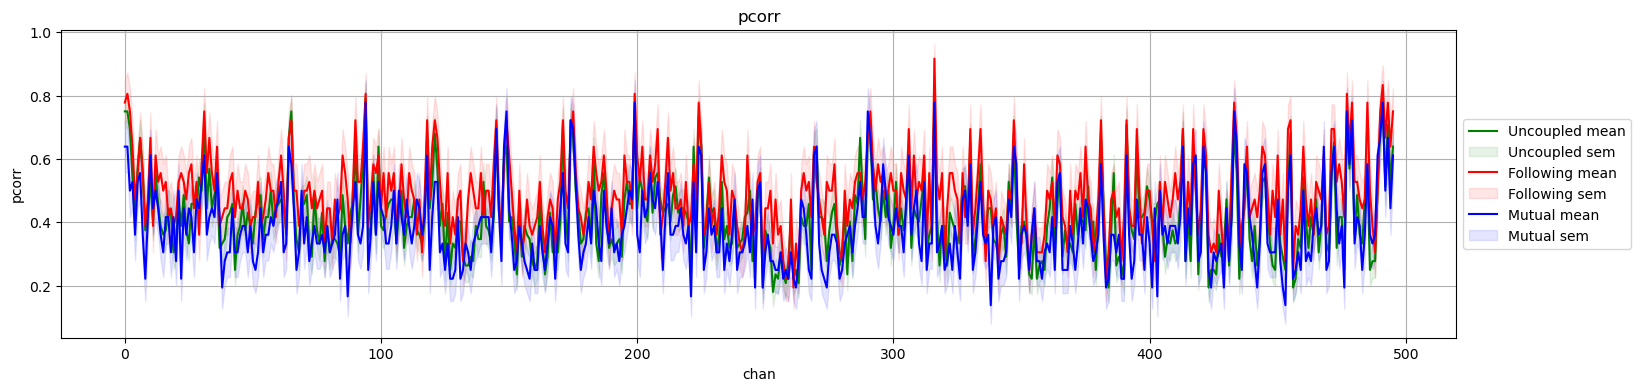

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6*3, 4))
color_3st=['green','blue','black']
for st in range(3):
    plt.plot (np.arange(496),mean_trl[st,:],color=condicolors[st])
    plt.fill_between(np.arange(496),mean_trl[st,:]-sem_trl[st,:],\
                mean_trl[st,:]+sem_trl[st,:],\
                    color=condicolors[st], alpha=.1)
plt.xlabel("chan")
plt.ylabel("pcorr")
plt.title('pcorr')
plt.grid()
plt.legend(['Uncoupled mean', 'Uncoupled sem', 
    'Following mean', 'Following sem','Mutual mean','Mutual sem'],ncol=1,
    loc='center left', bbox_to_anchor=(1, 0.5))


Text(0.5, 1.0, 'pcorr (mutual)')

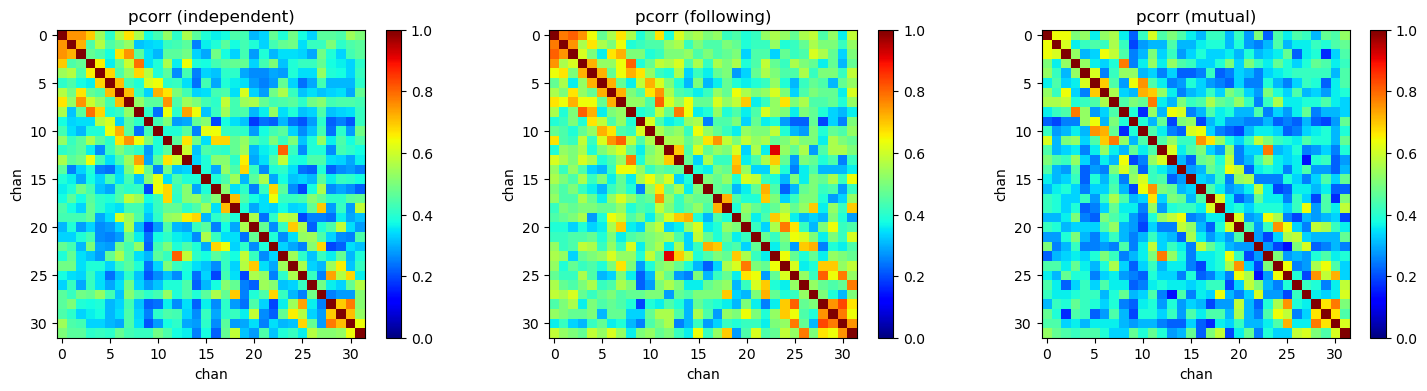

In [12]:
fig, ax = plt.subplots(1,3,figsize=(6*3, 4))
plt.sca(ax[0])
plt.imshow(mean_trl_indi,vmin=0,vmax=1,cmap='jet')
plt.colorbar()
plt.xlabel("chan")
plt.ylabel("chan")
plt.title('pcorr (independent)')

plt.sca(ax[1])
plt.imshow(mean_trl_fol,vmin=0,vmax=1,cmap='jet')
plt.colorbar()
plt.xlabel("chan")
plt.ylabel("chan")
plt.title('pcorr (following)')

plt.sca(ax[2])
plt.imshow(mean_trl_mut,vmin=0,vmax=1,cmap='jet')
plt.colorbar()
plt.xlabel("chan")
plt.ylabel("chan")
plt.title('pcorr (mutual)')

Text(0.5, 1.0, 'pcorr (mutual - independent)')

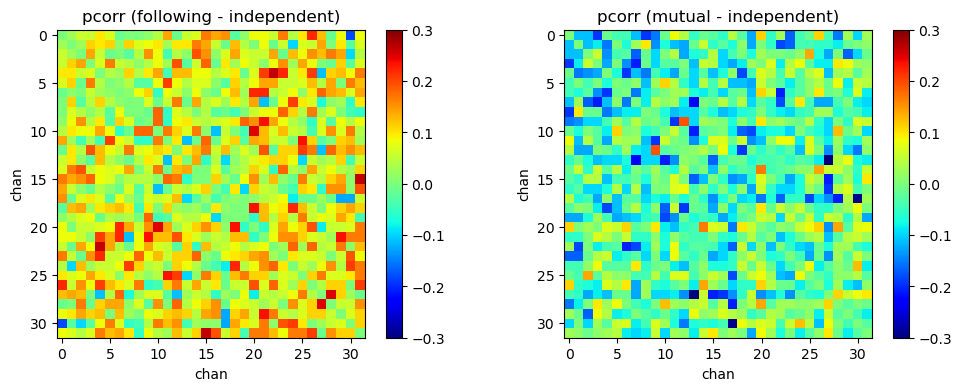

In [13]:
fig, ax = plt.subplots(1,2,figsize=(6*2, 4))
plt.sca(ax[0])
plt.imshow(mean_trl_fol-mean_trl_indi,vmin=-0.3,vmax=0.3,cmap='jet')
plt.colorbar()
plt.xlabel("chan")
plt.ylabel("chan")
plt.title('pcorr (following - independent)')

plt.sca(ax[1])
plt.imshow(mean_trl_mut-mean_trl_indi,vmin=-0.3,vmax=0.3,cmap='jet')
plt.colorbar()
plt.xlabel("chan")
plt.ylabel("chan")
plt.title('pcorr (mutual - independent)')

In [14]:
# 3 states pcorr
eeg_partial_correlation144x2 # 144x2x7x32x32
pcorr_indi=np.zeros((2,7,72,32,32))
pcorr_fol=np.zeros((2,7,36,32,32))
pcorr_mut=np.zeros((2,7,36,32,32))

for syn in range(2):
    for freq in range(7):
        # Independet
        mat1=eeg_partial_correlation144x2[syn2_condi4_ind[syn][0],0,freq,:,:].astype('bool')
        mat2=eeg_partial_correlation144x2[syn2_condi4_ind[syn][0],1,freq,:,:].astype('bool')
        mat3=eeg_partial_correlation144x2[syn2_condi4_ind[syn][1],0,freq,:,:].astype('bool')
        mat4=eeg_partial_correlation144x2[syn2_condi4_ind[syn][2],1,freq,:,:].astype('bool')
        pcorr_indi[syn,freq,:,:,:]=np.concatenate((mat1,mat2,mat3,mat4),axis=0)


        # Following
        mat1=eeg_partial_correlation144x2[syn2_condi4_ind[syn][1],1,freq,:,:].astype('bool')
        mat2=eeg_partial_correlation144x2[syn2_condi4_ind[syn][2],0,freq,:,:].astype('bool')
        pcorr_fol[syn,freq,:,:,:]=np.concatenate((mat1,mat2),axis=0)


        # Mutual
        mat1=eeg_partial_correlation144x2[syn2_condi4_ind[syn][3],0,freq,:,:].astype('bool')
        mat2=eeg_partial_correlation144x2[syn2_condi4_ind[syn][3],1,freq,:,:].astype('bool')
        pcorr_mut[syn,freq,:,:,:]=np.concatenate((mat1,mat2),axis=0)



In [15]:
# organzie into 496 edges
pcorr496_indi=np.zeros((2,7,72,496))
pcorr496_fol=np.zeros((2,7,36,496))
pcorr496_mut=np.zeros((2,7,36,496))
for syn in range(2):
    for freq in range(7):
        e=0
        for i in range(32):
            for j in range(32):
                if i<j: # use indicies to remove half of edges and colors and the diagonal
                    pcorr496_indi[syn,freq,:,e]=(pcorr_indi[syn,freq,:,i,j])
                    pcorr496_fol[syn,freq,:,e]=(pcorr_fol[syn,freq,:,i,j])
                    pcorr496_mut[syn,freq,:,e]=(pcorr_mut[syn,freq,:,i,j])
                    e+=1

In [16]:
# t-test try out
from scipy import stats
syn=1
freq=6
e=495
a=pcorr496_indi[syn,freq,:,e]
b=pcorr496_fol[syn,freq,:,e]
statistic, pvalue = stats.ttest_ind(a, b)
pvalue

1.0

In [17]:
# t-test
from scipy import stats
P496_fol_indi=np.zeros((2,7,496))
P496_mut_indi=np.zeros((2,7,496))
for syn in range(2):
    for freq in range(7):
        for edge in range(496):
            statistic, P496_fol_indi[syn,freq,edge]=stats.ttest_ind(pcorr496_indi[syn,freq,:,edge],
                                                                 pcorr496_fol[syn,freq,:,edge])
            statistic, P496_mut_indi[syn,freq,edge]=stats.ttest_ind(pcorr496_indi[syn,freq,:,edge], 
                                                               pcorr496_mut[syn,freq,:,edge])

P496_2compares=[P496_fol_indi,P496_mut_indi]

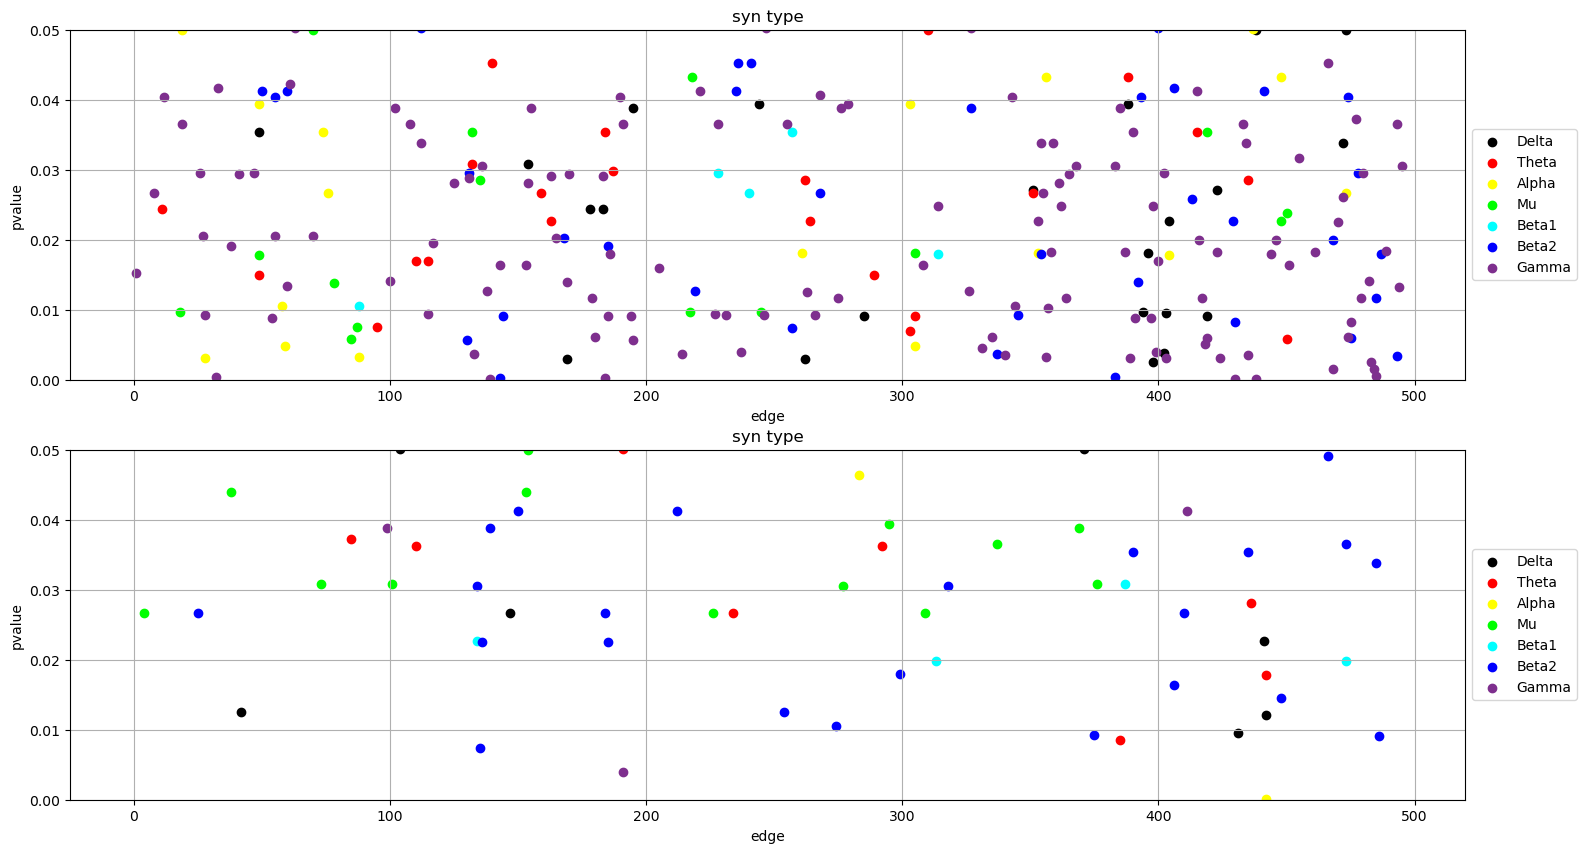

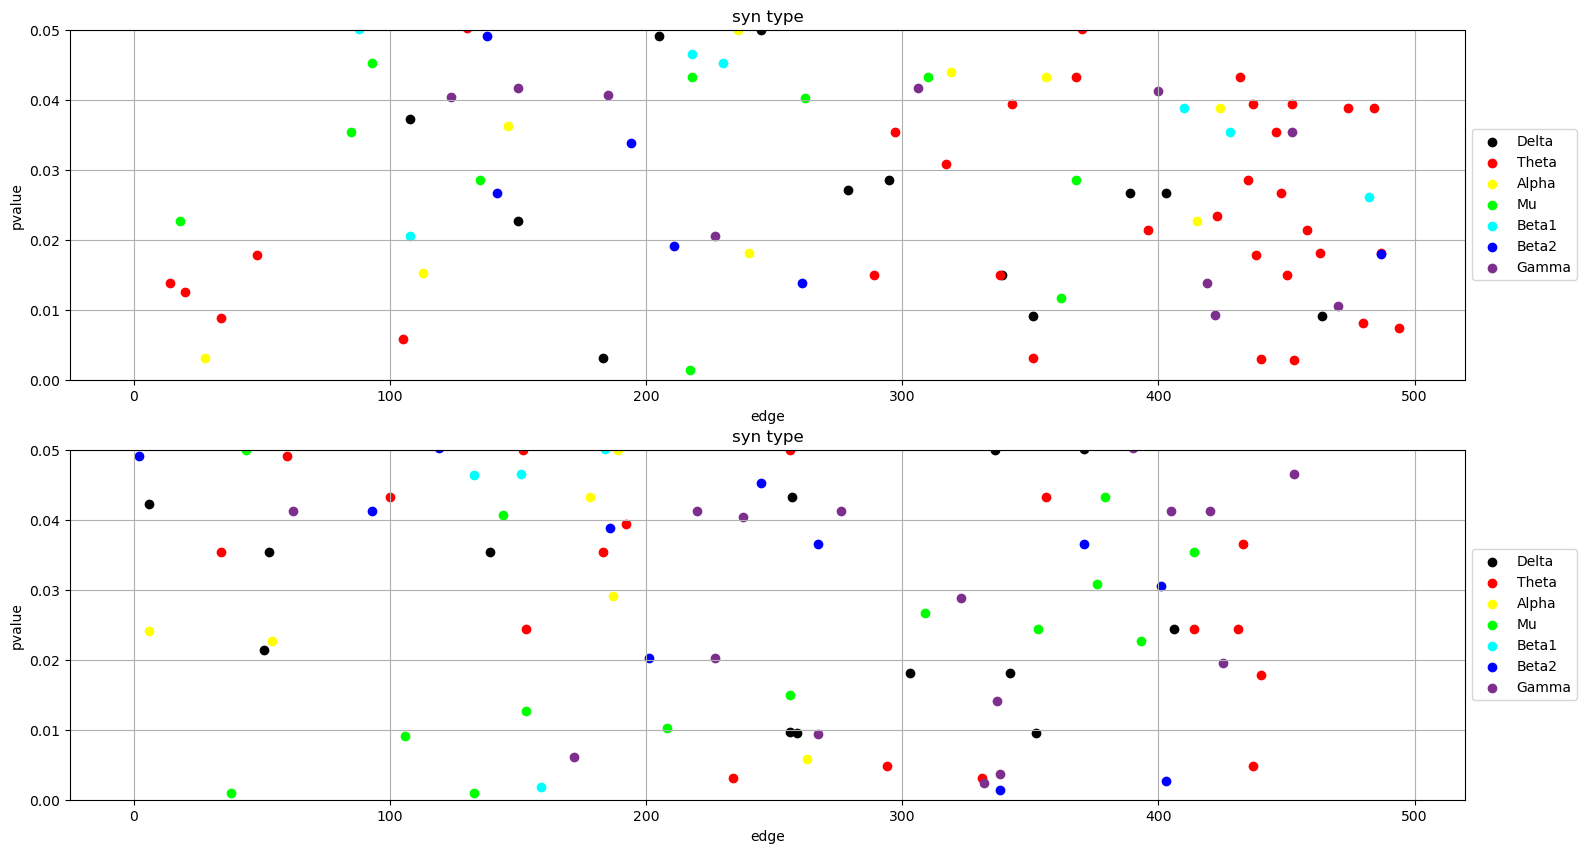

In [36]:
for c in range(2):
    fig, ax = plt.subplots(2,1,figsize=(6*3, 10))
    color_3st=['green','blue','black']
    for syn in range(2):
        plt.sca(ax[syn])
        for freq in range(7):
            plt.scatter (np.arange(496),P496_2compares[c][syn,freq,:],
                      color=freq7colors[freq])

        plt.xlabel("edge")
        plt.ylabel("pvalue")
        plt.ylim(0,0.05)
        plt.title('syn type')
        plt.grid()
        plt.legend(band_labels,ncol=1,
            loc='center left', bbox_to_anchor=(1, 0.5))